# Checkpoint 1: Neural networks and deep learning
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)

In this checkpoint exercise, we will use neural networks to predict the **type** of weather *given* the available ground observations. You will be using observation data from **June 2019** across all UK Met Office weather stations.

### Notes on the Dataset
* You will be using weather observation data from the UK Met Office Datapoint service
* Ground observations are made hourly at weather stations across the length of the UK 
* The data sample covers data from June 2019
* Data collections for each day starts at 6.30pm. All observation data is listed in one day blocks
* The time value column refers to the number of minutes after midnight 
* `Null` values for some features are expected (e.g. Wind Gust)
* Data import and preparation is already provided 


This week, I am not providing example notebooks like `lecture2.ipynb` and `data-science-tools.ipynb` for Unit 2, though these may still be useful to you. Instead, I am **providing the imports for all of the modules and classes that you should need.** Think of these as LEGO blocks; you have the ones you need but may look up how to "assemble" them.

### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10am on Friday 9 October 2021** 
- This CP exercise sheet is divided into **6 sections**, corresponding to parts of the lecture, giving a maximum of **10 marks** in total:

| <p align='left'> Title                         | <p align='left'> Exercise nos. | <p align='left'> Number of marks |
| ------------------------------------- | ----- | --- |
| <p align='left'> 1. Conceptual questions               | <p align='left'>  1–5  | <p align='left'> 3 |
| <p align='left'> 2. Data preprocessing and RandomForest                | <p align='left'>  6–9  | <p align='left'> 2. |
| <p align='left'> 3. Neural networks in `scikit-learn`  | <p align='left'>  10–11 | <p align='left'> 1.5 | 
| <p align='left'> 4. Neural networks in `Keras`         | <p align='left'> 12–13 | <p align='left'> 2 |
| <p align='left'> 5. Regularisation                     | <p align='left'> 14–15 | <p align='left'> 1.5 |
| <p align='left'> **Total** | | <p align='left'> **10** |

- The total number of marks allocated for this CP is 10,
    - 1 additional mark can be given (maximimally up to 10 marks in total) for "bonus" exercise on hyperparameter optimisation. If you are pressed for time, focus on the first five sections; those are the core ones.
    - Half marks may be deducted for code legibility (i.e. very difficult to tell what you are doing), or for badly formated plots (i.e. no legends, axis labels etc.). The TAs will use their discression for this so comment code when applicable and keep relevant information in your plots.

_Note:_ You can suppress double-printing of plots from the `plot` module by either _(a)_ adding a semicolon after the function call (_i.e._ `plot.<method>(...);`), or _(b)_ by capturing the return `pyplot.Figure` object as a variable (_i.e._ `fig = plot.<method>(...)`).

## Preamble

In [1]:
# Standard import(s)
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.inspection import PartialDependenceDisplay
from sklearn import metrics
%matplotlib inline

# Suppress unnecessary ConvergenceWarnings and DeprecationWarnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Set a random seed variable to make workbook reproducible
seed=5
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
tf.compat.v1.set_random_seed(seed)

# Switch off multi-threading for TensorFlow
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                  inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
K.set_session(sess)

In [2]:
# Load in the prepared weather data
obs = pd.read_csv('weather.csv')
obs.head()

,StationID,StationName,Elevation,Latitude,Longitude,Date,Time,Gust,Temperature,Visibility,WindDirection,WindSpeed,Pressure,PressureTrend,DewPoint,Humidity,Type
0,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1020,NaN,16.1,30000.0,E,8.0,1019.0,F,11.6,74.5,0
1,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1080,NaN,14.9,22000.0,E,8.0,1019.0,F,11.8,81.5,0
2,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1140,NaN,14.0,14000.0,E,6.0,1018.0,F,11.6,85.4,0
3,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1200,NaN,12.9,12000.0,ENE,2.0,1019.0,R,11.0,88.1,0
4,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1260,NaN,12.0,9000.0,E,2.0,1019.0,R,10.9,92.9,1


In [3]:
obs.shape

(106553, 17)

In [4]:
obs.describe()

,StationID,Elevation,Latitude,Longitude,Time,Gust,Temperature,Visibility,WindSpeed,Pressure,DewPoint,Humidity,Type
count,106553.000000,106553.000000,106553.000000,106553.000000,106553.000000,7703.000000,106442.000000,92662.000000,102060.000000,99530.000000,106402.000000,106397.000000,106553.00000
mean,6147.845636,114.466594,53.673022,-2.829034,702.914418,33.043749,14.958912,25698.164404,8.999510,1018.748337,10.348008,76.185240,0.99603
std,15821.503845,171.669120,2.466079,2.269594,412.057262,13.424855,4.294516,14263.873943,6.087882,6.327468,3.120565,17.208653,0.92971
min,3002.000000,2.000000,49.207900,-10.250000,0.000000,0.000000,-1.200000,20.000000,0.000000,976.000000,-28.200000,0.800000,0.00000
25%,3204.000000,20.000000,51.565000,-4.149000,360.000000,29.000000,12.000000,14000.000000,5.000000,1015.000000,8.400000,65.300000,0.00000
50%,3414.000000,65.000000,53.175000,-2.663000,720.000000,32.000000,14.500000,25000.000000,8.000000,1018.000000,10.500000,79.200000,1.00000
75%,3769.000000,132.000000,55.285000,-1.097000,1020.000000,39.000000,17.500000,35000.000000,11.000000,1024.000000,12.500000,90.000000,1.00000
max,99142.000000,1245.000000,60.749000,1.348000,1380.000000,105.000000,31.600000,75000.000000,81.000000,1036.000000,22.700000,100.000000,3.00000


For this exercise we will use **8** input features (provided) and clean the data:

In [5]:
# Define 8 input feature variables, 1 target variable data, and names of the 3 weather types
features = ['Latitude', 'Elevation', 'Temperature', 'Visibility', 'WindSpeed', 'Pressure', 'Humidity', 'WindDirection']
output   = ['Type']
wtype    = ['Clear', 'Cloudy', 'Precip']

Define derived dataset containing only the relevant columns and rows.

In [6]:
# Reduce to feature and type columns
dataset = obs[features + output]

# Drop duplicates and null values 
dataset = dataset.drop_duplicates().dropna()

# Drop unrecorded weather type
dataset = dataset[dataset.Type != 3]

# Check shape 
dataset.shape

(86313, 9)

## 1. Conceptual questions (3 Marks)
---
This section covers **5** exercises on conceptual understanding of neural networks.

#### 1.1. Which are the most used activation functions and why do we (typically) need non-linear activation functions in neural networks? (0.5 mark)

a) Most used activation functions:
    <br>- Sigmoid
    <br>- ReLU
    <br>- tanh
    <br>- Softmax
    
b) We use non-linear activation funcitons so that we can perform backpropagation that is necessary to learn a non-linear fit. The derivatives of linear functions are constant and means that we cannot go back in a multi-layer network to understand which weights can provide a better prediction. Hence we have no information on how the weights need to be updated to reduce the loss function and improve the fit.

#### 1.2. Why do we need deep neural networks and which are the main differences between deep and shallow learning? (0.5 Mark)

Although a single layer NN can act like a universal approximator its performance does not scale well with the size of input data. Increasing the depth of NN layers to 2 or more (deep NN) allows performance to scale much better with the size of input data, which means equally good perfomance can be achieved with much less data.

The main differences between deep and shallow learning are:

- A shallow network requires training features to be manually chosen from the input data.

- This means a shallow network cannot exploit high-dimensional data as manual feature selection would become unfeasable at high-dimensionality.

- Once features are selected they can only be used in the form they are provided.


- A deep network on the other hand is capable of learning relevant features on its own and in this way can perform autonomous feature selection. 

- This allows a deep network to exploit high-dimensional data as it can handle it better at the stage of feature selection.

- Furthermore, through the connection of multiple layers deep networks can automatically combine selected features in complex ways to form useful abstractions of the input data that help with classification.


#### 1.3. Discuss the Bias-variance trade-off and its relation to underfitting and overfitting of a model. Which are the caractheristics of an ideal model?  (0.5 mark)

The principle of the Bias-variance trade-off is key to understanding the behaviour of predictive learning models once they are applied to unseen data.

In the case of underfitting we have a model that is too simple to capture the complexity of the input dataset and therefore shows a poor performance on the training  data. This corresponds to a high bias.

On the other hand, for the case of overfitting we have a model that is too complex for the input dataset and makes a fit to the noise in the training data which is not present in the validation or testing sets. This results in increasingly lower loss on the training set with number of epochs, while validation set loss initially falls but then starts to increase again as overfitting takes place. The growing difference in loss between the training and validation sets corresponds to the model having a high variance.

An ideal model is characterised by a low bias and a low variance. This corresponds to a model which can achieve a very low and continually decreasing training loss with the validation loss following very closely behind. 

#### 1.4. Given a neural network with 4 input nodes, 2 layers with 5 nodes each, and 1 output node, what is the total number of free (trainable) parameters in the network? Does it matter which activation function(s) are used?  (0.5 mark)

This network has 1 input layer, 2 hidden layers and 1 output layer. We will assume that the network is fully connected and uses a bias node at each layer except in the output layer, with the bias node only connected to the forward layer neurons. In this case each of the 4 input nodes + bias node are connected to each of the 5 nodes in hidden layer 1. Futhermore, each of the 5 nodes + bias node in hidden layer 1 are then individually connected to each of the 5 nodes in hidden layer 2. Finally, each of the 5 nodes + bias node from hidden layer 2 are individually connected to the single output node.

This corresponds to 25 connections between input and hidden layer 1, 30 connections between hidden layers 1 and 2 and 6 connections between hidden layer 2 and the output node. Each connection in the network corresponds to a trainable parameter. Therefore, there are a total of 25+30+6=61 trainable parameters in this network.

For the number of trainable parameters: It does not matter which activation function is used as activation functions only take in the previous layer of weighted node activations + the bias term values but do not alter the network connections which determine the number of trainable parameters.

However, the choice of activation function matters as the activation function should be chosen to map to our desired output.

#### 1.5. What are appropriate choice for _(a)_ the number of output nodes and _(b)_ output activation function(s) for each of the following tasks, and why? (0.5 mark)

1. Regression of the $x$, $y$, and $z$ coordinates of a single particle in an arbitrary coordinate system
2. Regression of particle energy of a single particle
3. Classification of two processes (signal vs. background)
4. Classification among *N* classes (dog vs. cat vs. fish vs. ...)

1. a) 3 output nodes for each coordinate axis.
   <br>b) The linear activation function as it has a range of -infinity to +infinity to capture the full range of numbers for each coordinate value.
   
   
2. a) 1 output node as only a single variable, energy, is being predicted.
   <br>b) The ReLU activation function as it has a range of 0 to +infinity and can therefore only return a numerical value greater than 0, as particle energy cannot be negative.
   
   
3. a) 1 output node that can be inferred as probability of predicting one of the classes (eg signal)
   <br>b) The sigmoid activation function as it returns values between 0 and 1 and can therefore be inferred as how confident the model is of the instance being in the "true" class.
   
   Also the softmax function can be used with 2 nodes that give the probability of being signal and background respectively.
   <br>
4. a) N output nodes, 1 for each class.
   <br>b) The softmax function as it returns values between 0 and 1 for each output node with all the values summing to 1. This allows the output node values to be interpreted as probabilities for each class.

**1.6. Given some data points and regression/classification problem, write the appropite cost function and compare your solution to that from sklearn (0.5 marks)** 

**Regression** 

A good **loss function** for regression is the **Mean Squared Error**. 

For $N$ samples with targets $Y$, our prediction $\bar{Y}$ has an MSE of:


$\mathrm{MSE} = \frac{\sum[(\bar{Y}-Y)^2]}{N}$

In [7]:
## Regression Problem

# 3 Targets for regression 
Y = np.array([0.,1.,0.5])
# 3 Predicted values (at random)
YPred = np.random.rand(3)

In [8]:
#cost function (Mean Square Error):
def mse(YPred,Y):
    # Your solution here
    error = (1/Y.size)*(np.sum((YPred-Y)**2))
    return error

In [9]:
# Comparing our function to the sklearn MSE
prediction = np.random.rand(Y.shape[0])
print ("My MSE function is {}".format("Correct" if mse(prediction,Y) == metrics.mean_squared_error(prediction,Y) else "Wrong"))

My MSE function is Correct


**Classification**

Log Loss from the lecture notes is appropiate for binary classification, where our prediction is a probaility of `label = 1`.

In [10]:
#10 Random class labels (0 or 1)
Y = np.random.randint(0,2,10)
# 10 Random Probabilities
YPred = np.random.rand(10)

In [11]:
def logloss(YPred,Y):
    #your code here
    log_loss = (-1/Y.size)*(np.sum((Y*np.log(YPred))+((1-Y)*(np.log(1-YPred)))))
    return log_loss

In [12]:
# Check it matches the sklearn log_loss
logloss(YPred,Y) == metrics.log_loss(Y.astype(int),YPred)

True

## 2. Data preprocessing and RTs (2 mark)
---
This section covers **4** exercises on data preparation, feature standardisation, and dataset splitting.

In [13]:
# Relevant import(s) for this section
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

---
**_Comment on target format and one-hot encoding:_** By default, the target column (`Type`) contains one integer (0, 1, or 2) for each example, the integer specifying one of three possible types of weather. However, for doing multi-class classification (which this is), we want our neural network to have one output node per class (_i.e._ 3 output nodes in this case), such that the activation of each output node is interpreted as the likelihood for a given sample being of the type in question. Therefore, the target should also be a 3-element vector for each sample; this vector should be all zeros, except for a $1$ at the index corresponding to the type in question. This is called **one-hot encoding**, and a few examples are shown below:

- type = 0 $\to$ one-hot = $[1, 0, 0]$ for 3 classes
- type = 1 $\to$ one-hot = $[0, 1, 0]$ for 3 classes
- type = 2 $\to$ one-hot = $[0, 0, 1]$ for 3 classes

This is the target towards which a neural network classifier is trained: That is, ideally, for an example of type 0, the network will output a large activation ($\approx 1$) on the first output node (interpreted as a large likelihood for the first weather type), and very small activations ($\ll 1$) on the two other output nodes (intepreted as small likelihoods for the two other weather types); and so on.

The same type of one-hot encoding can be performed for any number of target classes $N_{c}$, which just results in $N_{c}$-element target vectors with a single non-zero entry each.

To be user friendly, however, `scikit-learn` allows us to use integer targets for multi-class classification — it does the one-hot encoding for us "under the hood." Similarly, `keras`, _can_ also allow us to use integer targets for multi-class classification, provided we use the appropropriate loss (`sparse_categorical_crossentropy`). Otherwise (if we use `categorical_crossentropy` loss), it expects one-hot encoded targets. Which approach you choose is up to you — but now you know what goes on.

---

#### 2.1. Prepare the feature and target arrays (0.5 mark)
- Randomly sample **3,500** observations per weather type (**10,500** observations in total) from `dataset` into a new `pandas.DataFrame`; call it `sample`.
- One-hot encode the **wind direction** variable (_i.e._ $N$ to $[1, 0, \ldots, 0]$, $NNE$ to $[0, 1, \ldots, 0]$, _etc._ ), to allow us to input it to the neural network. There are 16 unique directions so we need to transform 1 feature into 16 features.
The exact order of the encoding (_i.e._ which direction corresponds to which index) doesn't matter. *Hint:*
  - *Either:* Use the scikit-learn `ColumnTransformer` with the `OneHotEncoder` applied to the `WindDirection` column, and let the remainder of the features pass through un-transformed.
  - *Or:* Use the `OneHotEncoder` class directly on the `WindDirection` column (use `sparse=False` in the `OneHotEncoder` constructor), and then concatenate with a `numpy.array` containing the remaining features.
- Define `numpy.arrays` named `X` and `y` containing the training features (the 7 unmodified ones plus the one-hot encoded wind directions) and target, respectively.
- Argue whether the shapes of `X` and `y` are as expected/as they should be.


In [14]:
#For convenience concatenate the wind direction and other features 
# in the order that you can use this feature name variable
feature_names = list(range(16))+features[:-1]
print(feature_names)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 'Latitude', 'Elevation', 'Temperature', 'Visibility', 'WindSpeed', 'Pressure', 'Humidity']


In [15]:
sample = dataset.groupby("Type").sample(3500,random_state=1)
sample

,Latitude,Elevation,Temperature,Visibility,WindSpeed,Pressure,Humidity,WindDirection,Type
30399,52.242,99.0,20.5,11000.0,3.0,1014.0,54.2,ESE,0
45306,51.479,25.0,13.0,45000.0,3.0,1020.0,68.0,NE,0
84305,51.279,72.0,21.2,30000.0,9.0,1025.0,38.1,NNW,0
87099,52.949,21.0,17.6,40000.0,6.0,1026.0,70.3,NNW,0
18725,54.501,255.0,7.3,30000.0,2.0,1019.0,88.2,WNW,0
...,...,...,...,...,...,...,...,...,...
54315,55.050,285.0,9.7,11000.0,9.0,1010.0,94.0,S,2
15718,53.175,68.0,11.1,14000.0,13.0,1019.0,89.7,NNE,2
7733,56.326,35.0,14.4,1200.0,1.0,1019.0,100.0,W,2
112,58.954,26.0,10.5,400.0,9.0,1017.0,100.0,ESE,2


In [16]:
encode = OneHotEncoder(sparse=False) 
encoded_df = pd.DataFrame(encode.fit_transform(sample["WindDirection"].values.reshape(-1, 1)))
sample.reset_index(drop=True, inplace=True)
enc_sample = pd.concat([encoded_df, sample], axis=1)
enc_sample.drop(columns=["WindDirection"], inplace=True)
enc_sample

,0,1,2,3,4,5,6,7,8,9,...,14,15,Latitude,Elevation,Temperature,Visibility,WindSpeed,Pressure,Humidity,Type
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,52.242,99.0,20.5,11000.0,3.0,1014.0,54.2,0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,51.479,25.0,13.0,45000.0,3.0,1020.0,68.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,51.279,72.0,21.2,30000.0,9.0,1025.0,38.1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,52.949,21.0,17.6,40000.0,6.0,1026.0,70.3,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,54.501,255.0,7.3,30000.0,2.0,1019.0,88.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,55.050,285.0,9.7,11000.0,9.0,1010.0,94.0,2
10496,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,53.175,68.0,11.1,14000.0,13.0,1019.0,89.7,2
10497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,56.326,35.0,14.4,1200.0,1.0,1019.0,100.0,2
10498,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,58.954,26.0,10.5,400.0,9.0,1017.0,100.0,2


In [17]:
X = enc_sample.drop("Type", axis=1)
y = enc_sample["Type"]

In [18]:
X.shape

(10500, 23)

In [19]:
y.shape

(10500,)

The number of rows should be the same for both the features and the target values, which should match the sample dataset number of rows. This is the case here.

The feature dataset should contain one less column than the complete sample dataset and this column should correspond to the single column of the target values. This is the case here, with the feature columns and single target column adding up to the encoded sample dataset column number.

Therefore, the shapes of X and y are as they should be.

#### 2.2. Train a Random Forest, evaluate performance, explore features (1.5 mark)

Decision trees work well with a mixture of features (of different scales, and both binary and continuous data), so we will train a random forest to do the job of categorisation.

You are given the train test split (70% training):

In [20]:
#Import random fosets and confusion matrix metric
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

# split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape,y_train.ravel().shape)

(7350, 23) (3150, 23) (7350,)


1. Train a `RandomForestClassifier` with a `GridSearchCV` over the following input parameters to the mode'. Split the dataset into only 3 cross validation folds to make it a little faster (Hint: see `GreidSearchCV` function documentation)
2. Check the overal accuaracy on the testing set
3. What is the best set of hyperparametrs the scan has found? 

*Hint:* the final random forest that is chosen can be returned with th the `best_estimator_` member of the `GridSearchCV` object

In [21]:
# We scan a broad range of parameters to use for the RandomForest
rf_dic={
    "n_estimators":[10,50,200,500],
    "max_features": ["sqrt","log2"],
    "criterion": ["gini"],
    "max_depth": [4,8,30]
    }

In [22]:
rfc = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(estimator=rfc, cv=3, param_grid=rf_dic)
grid_search.fit(x_train.values, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini'], 'max_depth': [4, 8, 30],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 50, 200, 500]})

In [23]:
overall_acc = grid_search.score(x_test.values,y_test)
print("Overall accuracy on testing set: ",overall_acc)

Overall accuracy on testing set:  0.7365079365079366


In [24]:
grid_search.best_estimator_
print("Best set of hyperparametrs the scan has found:",grid_search.best_estimator_)

Best set of hyperparametrs the scan has found: RandomForestClassifier(max_depth=30, n_estimators=200, random_state=0)


---

**Understanding Classification Accuracy**

4. Use the `confusion_matrix` method on the **test data** to return the confusion matrix normalised over the true lables, i.e. sum over rows should sum to 100%. Use the given colormap to plot the confusion matrix in a heatmap.
    - Define the axis tick names to represent Clear, Cloudy or Precip
    - Use suitable x and y axis labels
    
5. What are the true positive rates for clear, cloudy and perp? 
6. What is the probability that rain is forcast on a sunny day?

In [25]:
y_pred = grid_search.predict(x_test.values)

In [26]:
cm = confusion_matrix(y_test,y_pred)

In [27]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=wtype)

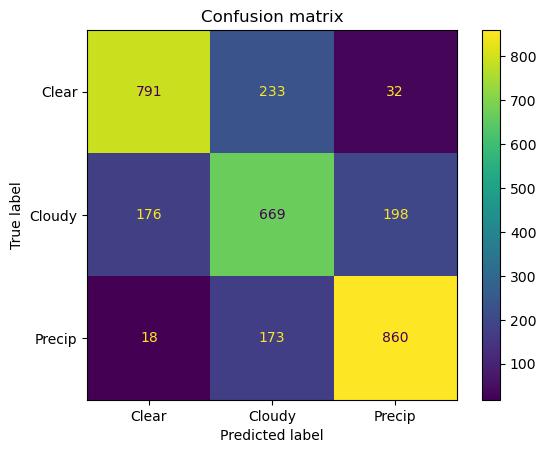

In [28]:
disp.plot()
plt.title("Confusion matrix")
plt.show()

In [29]:
print("TP rate for clear: ",cm[0,0]/y_test.value_counts()[0])
print("TP rate for cloudy: ",cm[1,1]/y_test.value_counts()[1])
print("TP rate for precip: ",cm[2,2]/y_test.value_counts()[2])

TP rate for clear:  0.7490530303030303
TP rate for cloudy:  0.6414189837008629
TP rate for precip:  0.8182683158896289


In [30]:
print("Probability rain is forcast on a sunny day: ",cm[0,2]/y_test.value_counts()[0])

Probability rain is forcast on a sunny day:  0.030303030303030304


---
**Understanding Feature Importance**

There are several ways to understand which **features are important** to the 
decision tree. The most common is to look at `feature_importances_` list which is calculated at training time. This quantifies by how much each feature splits the dataset, the higher the number, the more imporant the feature. In random forests were we have 100s of trees, the importance is an gregate.


*Note:* below the code assumes the random forest CV search is still `grid_search`

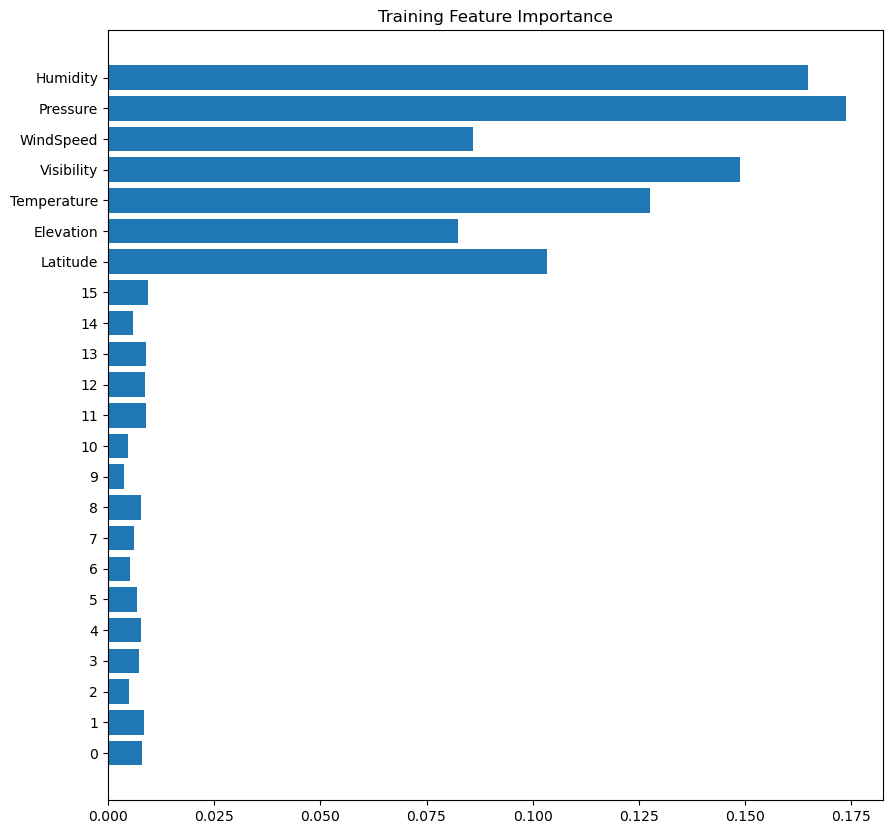

In [31]:
# Given plotting example for feature importance
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(range(23), grid_search.best_estimator_.feature_importances_)
ax.set_yticks(range(23),feature_names)
ax.set_title("Training Feature Importance")
plt.show()

E.g. In the RF I trained, wind direction has little impact on the performance, while Pressure, Visibility and Humidity seem like natural important features.

The problem with `feature_importances_` is that they are **calulated and biased towards the training dataset**, so may not represent the most relevant features for classifying on the **testing dataset**.


We can use `permutation_importance` to get a more accurate representation on the feature importance. 

In [32]:
from sklearn.inspection import permutation_importance

This function will randomly permute (shuffle) one feature at a time, and look at how much the accuracy changes. We can perform this permutation several times (`n_repeats`) and get an average impact on the accuracy, and a std deviation.

7. Complete the permutation importance function below
    - Use the test dataset
    - Permute each feature 20 times


In [33]:
best_rfc = grid_search.best_estimator_

In [34]:
result = permutation_importance(
    estimator=best_rfc, X=x_test.values,y=y_test, n_repeats= 20,random_state=42, n_jobs=2)

8. Make the feature importance plot as above using 
    - `result.importances_mean` as the feature importances
    - `result.importances_std` for the `barh` parameter `xerr=`
    - Comment on how the imporatnces change on the testing dataset

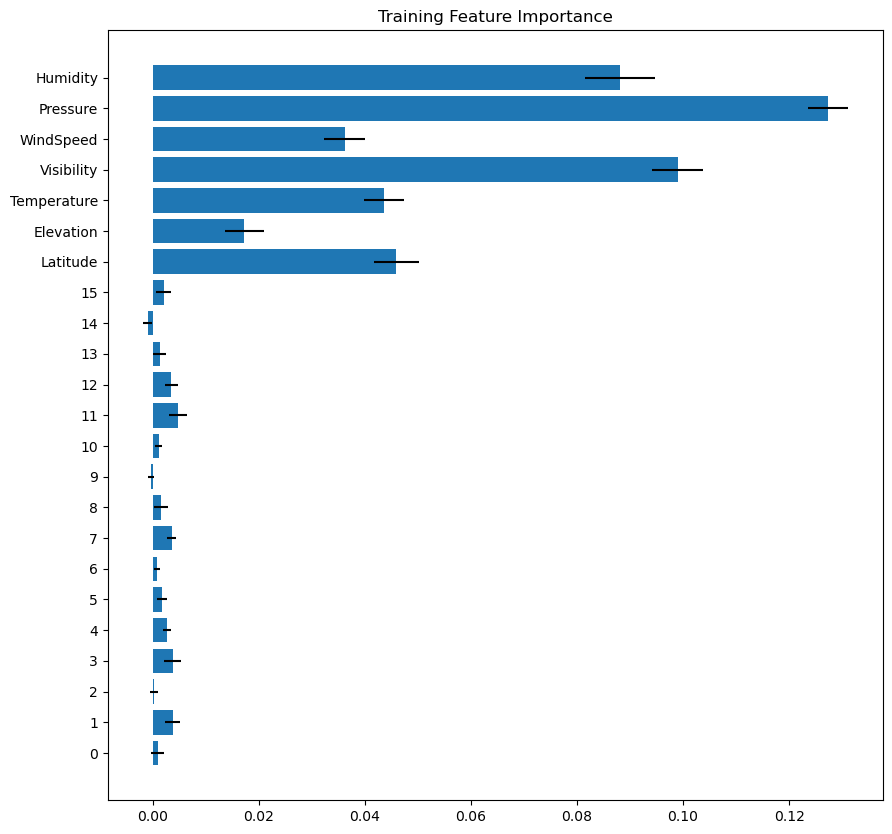

In [35]:
# Given plotting example for feature importance
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(range(23), result.importances_mean, xerr = result.importances_std)
ax.set_yticks(range(23),feature_names)
ax.set_title("Training Feature Importance")
plt.show()

The feature importances for almost all the variables decreases in the absolute scale. The relative importance for visibility overtakes the importance of humidity in terms of the permutation importance. Humidty, pressure and visibilty remain the three most important variables with the rest reducing in importance more dramatically.

---
Finally we can look at the impact of individual features on the probablity of a **particular class**.

Using `PartialDependenceDisplay` we choose a set of features that we allow to vary within a range, while other features remain fixed. We can look at how the probability estimate changes on average for any one of our targets. 

9. Complete the `PartialDependenceDisplay.from_estimator` function by:
    - adding your random forest estimator
    - using the first 100 data points of the test dataset as input
    - Use the `Humidity`, `Pressure` and `Visibility` features. These feature values are scanned while the others remain fixed (*Hint:* `features` parameter)
    - Look at the impact on the `Precipitaion` class probability (*Hint:* `target` parameter)
10. Comment on the trends shown over the 3 features on the probability it will rain.

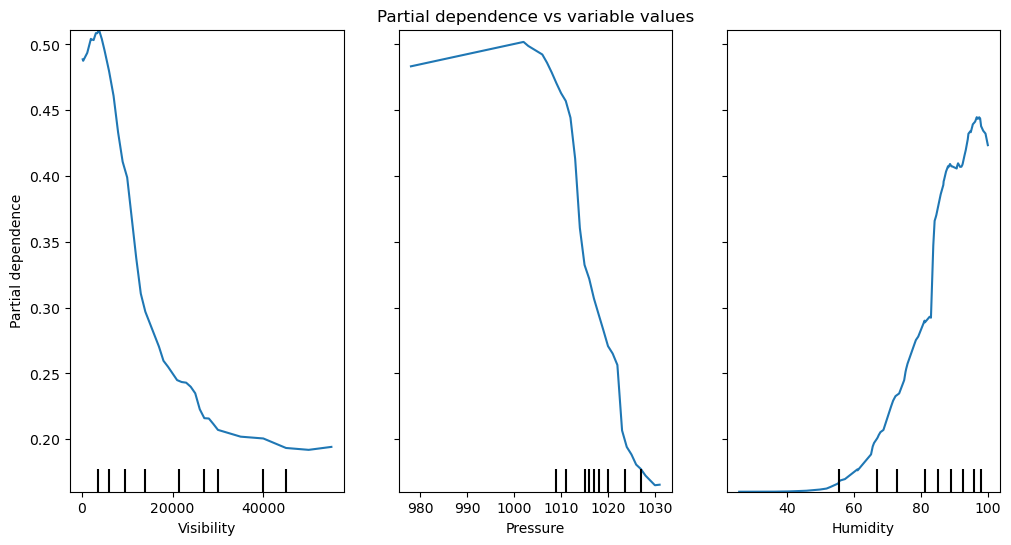

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Partial dependence vs variable values")
tree_disp = PartialDependenceDisplay.from_estimator(
    estimator= best_rfc, X=x_test[:100].values, features=(19,21,22), target=2,
    feature_names=feature_names,
    ax=ax)


As the Visibility and Pressure values increase the likelihood it will rain reduces. However, for the Humidity the trend is the opposite, with increasing humidity values the likelihood it will rain increases.

## 3. Neural networks in `scikit-learn` (1.5 mark)
---
This section covers exercises on constructing and training neural networks using the `scikit-learn` library, as well as evaluating neural network performance. `scikit-learn` provide many, very easy to use ML algorithms, including neural networks. These are called `MLPClassifier` (MLP = multi-layer perceptron; a historic name for densely connected, feed-forward neural networks) when used for classification, and `MLPRegressor` when used for regression. We will focus on the former for now.

In [37]:
# Relevant import(s) for this section
from sklearn.neural_network import MLPClassifier


#### 3.1. Standardise the relevant features  and split data (0.5 mark)
We need some additional processing of the input features to make them appropiate for the neural network. 

- Use our feature array `X`, and standardize the features.

    _Note:_ You shouldn't standardise the one-hot encoded wind directions; they already have the desired format. Perform a sanity check to make sure that the resulting features have the expected distributional properties (mean and standard deviation; or minimum and maximum value).
    - Hint:

        - Use the scikit-learn `StandardScaler`
        - Or use the scikit-learn `MinMaxScaler`

- Perform a sanity check to make sure that the resulting features have the expected distributional properties (mean and standard deviation; or minimum and maximum value).
    - The number of columns should match, and depending on the choice of standardisation, the last 7 columns should either have:
      - (Using `StandardScaler`) means = 0 and standard deviations = 1; or
      - (Using `MinMaxScaler`) min = 0, max = 1
      
- Reserve **30%** of data for testing. Check whether the resulting arrays have the expected shapes.

In [38]:
X[X.columns[16:]]

,Latitude,Elevation,Temperature,Visibility,WindSpeed,Pressure,Humidity
0,52.242,99.0,20.5,11000.0,3.0,1014.0,54.2
1,51.479,25.0,13.0,45000.0,3.0,1020.0,68.0
2,51.279,72.0,21.2,30000.0,9.0,1025.0,38.1
3,52.949,21.0,17.6,40000.0,6.0,1026.0,70.3
4,54.501,255.0,7.3,30000.0,2.0,1019.0,88.2
...,...,...,...,...,...,...,...
10495,55.050,285.0,9.7,11000.0,9.0,1010.0,94.0
10496,53.175,68.0,11.1,14000.0,13.0,1019.0,89.7
10497,56.326,35.0,14.4,1200.0,1.0,1019.0,100.0
10498,58.954,26.0,10.5,400.0,9.0,1017.0,100.0


In [39]:
scalar = StandardScaler()
scalar.fit(X[X.columns[16:]])

StandardScaler()

In [40]:
print("""Before standardisation
----------------------""")
print("Feature means: ",scalar.mean_)
print("Feature standard deviations:",np.sqrt(scalar.var_))

Before standardisation
----------------------
Feature means:  [5.38308992e+01 9.27939048e+01 1.45807238e+01 2.18916467e+04
 9.26361905e+00 1.01715162e+03 7.98668762e+01]
Feature standard deviations: [2.50809287e+00 8.71867301e+01 4.01393452e+00 1.48500620e+04
 6.24289541e+00 7.60599151e+00 1.68048489e+01]


In [41]:
X_trans = scalar.transform(X[X.columns[16:]])

In [42]:
scalar.fit(X_trans)

StandardScaler()

In [43]:
print("""After standardisation
----------------------""")
print("Feature means: ",scalar.mean_)
print("Feature standard deviations:",np.sqrt(scalar.var_))

After standardisation
----------------------
Feature means:  [ 6.60466391e-16  1.04212935e-16 -2.59855629e-16 -6.49639073e-17
  1.19100497e-16 -4.02776225e-15 -2.16546358e-17]
Feature standard deviations: [1. 1. 1. 1. 1. 1. 1.]


We can see after standarisation that all non-encoded features have mean of 0 and standard deviation of 1.

In [44]:
#Combining the one-hot encoded features with the standardised features
X = np.append(X[X.columns[:16]].values,X_trans,axis=1)

In [45]:
#Splitting the dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape,y_train.ravel().shape,y_test.ravel().shape)

(7350, 23) (3150, 23) (7350,) (3150,)


Resulting arrays have the expected shapes.

x_train and x_test have 23 features, y_train and y_test have the single target variable.

Sum of rows 7350+3150 = 10500 which is the number of rows in sample dataset.

#### 3.2. Construct, train, and evaluate a neural network  (1 mark)

- Create an `MLPClassifier` which
    - has **1 hidden layer of 50 neurons** 
    - has **no regularization term**
    - trains for a maximum of **100 epochs** 
    - uses a batch size of **32**
- Fit the classifier using the standard `.fit()` member method.
- Plot the loss function value as a function of number of epochs (0.5 of mark).
  You can access the loss history through the `.loss_curve_` attribute of the `MLPClassifier` instance. 

In [46]:
mlp = MLPClassifier(hidden_layer_sizes=(50),
                    alpha=0,
                    max_iter=100,
                    batch_size=32)
mlp.fit(x_train,y_train)

MLPClassifier(alpha=0, batch_size=32, hidden_layer_sizes=50, max_iter=100)

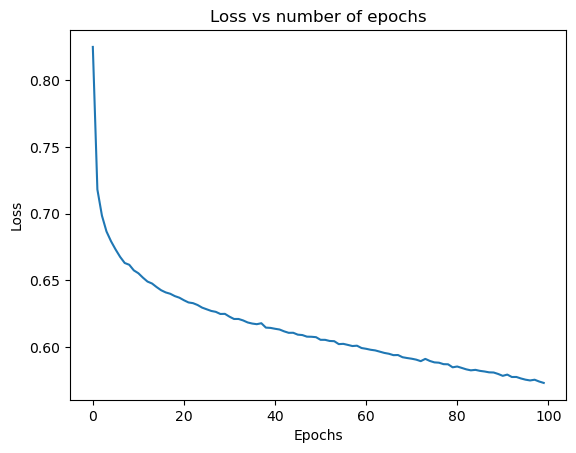

In [47]:
#mlp.loss_curve_
plt.plot(mlp.loss_curve_)
plt.title("Loss vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


- Using the testing dataset: 
    - Compute the overall accuracy for the classifier using the `MLPClassifier`'s `.score()` member method for both testing and training datasets.
    - Compute the confusion matrix (normalised in true labels), and plot it 
- Discuss the results

In [48]:
print("Overall accuracy for training set: ",mlp.score(x_train,y_train))
print("Overall accuracy for testing set: ",mlp.score(x_test,y_test))

Overall accuracy for training set:  0.7507482993197279
Overall accuracy for testing set:  0.7044444444444444


In [49]:
y_pred = mlp.predict(x_test)

In [50]:
cm = confusion_matrix(y_test,y_pred,normalize="true")

In [51]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=wtype)

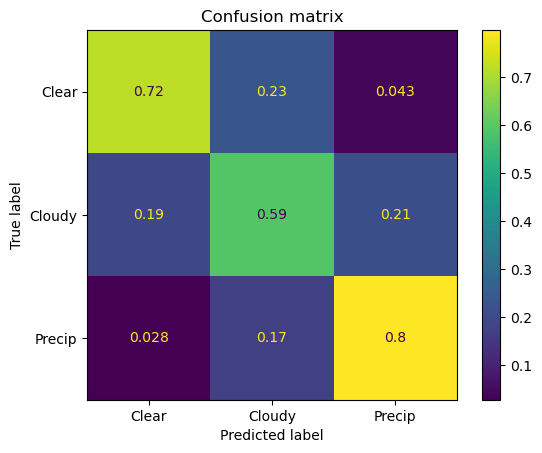

In [52]:
disp.plot()
plt.title("Confusion matrix")
plt.show()

The results show that the classifier is showing low variance as training and testing accuracy are similar. However, a high bias is seen as the accuracy on both the training and testing sets is not very high. In general we see that the loss value decreases with the number of epochs. This shows that the ML alorithm is training as expected and suggests that to reduce bias we could train the model for longer by increasing the number of epochs.

Through the confusion matrix we can see that the true positive(TP) rates for Cloudy are lowest while TP rates for Precip are highest, ie that Cloudy is classified correctly the least and Precip is classified correctly the most.

## 4. Neural networks in `Keras` (2 marks)
---
This section covers exercises on constructing and training neural networks using the `Keras` library. `scikit-learn` is very easy to use, but libraries like `Keras` provide a lot more flexibility, which is why we will be using these extensively in the last two units of the _'Data science tools and machine learning'_ track.

In [53]:
# Relevant import(s) for this section
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense

#### 4.1. Construct a neural network in `Keras` (1 mark)

- Create a `keras.Model` using the **Keras functional API**. The network should have:
    - An input layer with the same number of nodes as the number of features in `X`.
    - A single, densely connected hidden layer with **50 nodes** equipped with **ReLU activation**.
    - A densely connected output layer with **3 nodes** (the number of types of weather we're classifying) equipped with **softmax activation**.
- Compile the model the using the **Adam optimiser**, add `'accuracy'` as metric, and use either:
    - `categorical_crossentropy` loss, if you have one-hot encoded the targets `y`, or
    - `sparse_categorical_crossentropy` loss if you hare using integer-valued targets.
- Use the `.summary()` member method to print an overview of the model you have created, explain the output.

In [54]:
inputs = Input(shape=(23,))
x = Dense(50, activation="relu")(inputs)
outputs = Dense(3, activation="softmax")(x)
mdl = Model(inputs, outputs)

In [55]:
mdl.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [56]:
mdl.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
dense (Dense)                (None, 50)                1200      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 1,353
Trainable params: 1,353
Non-trainable params: 0
_________________________________________________________________


The output of the summary method shows that a model was compiled with an input layer (23 nodes), one hidden layer (50 nodes) and an output layer (3 nodes). There are 1200 and 153 trainable parameters in the hidden and output layers respectively, giving a total of 1353 trainable paramters for the neural network. All of the network parameters are trainable.

#### 4.2. Train a `Keras` neural network (1 mark)

- Use the `.fit()` member method to train the network on the **training dataset** for **100 epochs** with a **batch size of 32**. Use **20% of the data for validation** and make sure to have `Keras` **shuffle** the training data between epochs. Save the fit history by doing `history_mld = .....`
- Print the classification accuracy using the `.evaluate()` member method, for both the training and testing dataset. Comment on the results.
- Plot val_loss and loss functions from the fit history. On the same plot, plot the sklearn curve from the excercise above. Note the sklearn NN does not provide a complementary validation loss history, so only plot the training loss.
- Comment on the results of the overall accuracy compared to the scikit-learn method.

In [57]:
history_mdl = mdl.fit(x_train,y_train, epochs=100, batch_size=32, shuffle=True, validation_split=0.2)

C:\Users\Stefa\Anaconda3\envs\daml\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:1516: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/100
184/184 [==============================] - 1s 3ms/step - loss: 0.8618 - accuracy: 0.5799 - val_loss: 0.7667 - val_accuracy: 0.6218
Epoch 2/100
184/184 [==============================] - 0s 2ms/step - loss: 0.7312 - accuracy: 0.6607 - val_loss: 0.7309 - val_accuracy: 0.6408
Epoch 3/100
184/184 [==============================] - 0s 2ms/step - loss: 0.7070 - accuracy: 0.6721 - val_loss: 0.7207 - val_accuracy: 0.6524
Epoch 4/100
184/184 [==============================] - 0s 2ms/step - loss: 0.6947 - accuracy: 0.6770 - val_loss: 0.7119 - val_accuracy: 0.6544
Epoch 5/100
184/184 [==============================] - 0s 2ms/step - loss: 0.6861 - accuracy: 0.6804 - val_loss: 0.7058 - val_accuracy: 0.6592
Epoch 6/100
184/184 [==============================] - 0s 2ms/step - loss: 0.6793 - accuracy: 0.6881 - val_loss: 0.7007 - val_accuracy: 0.6612
Epoch 7/100
184/184 [==============================] - 0s 2ms/step - loss: 0.6740 - accuracy: 0.6905 - val_loss: 0.6949 - val_accuracy: 0.6578

Epoch 58/100
184/184 [==============================] - 1s 3ms/step - loss: 0.5976 - accuracy: 0.7316 - val_loss: 0.6733 - val_accuracy: 0.6959
Epoch 59/100
184/184 [==============================] - 1s 3ms/step - loss: 0.5966 - accuracy: 0.7287 - val_loss: 0.6816 - val_accuracy: 0.6830
Epoch 60/100
184/184 [==============================] - 0s 3ms/step - loss: 0.5965 - accuracy: 0.7303 - val_loss: 0.6757 - val_accuracy: 0.6878
Epoch 61/100
184/184 [==============================] - 0s 3ms/step - loss: 0.5955 - accuracy: 0.7308 - val_loss: 0.6816 - val_accuracy: 0.6857
Epoch 62/100
184/184 [==============================] - 0s 3ms/step - loss: 0.5935 - accuracy: 0.7323 - val_loss: 0.6807 - val_accuracy: 0.6946
Epoch 63/100
184/184 [==============================] - 1s 3ms/step - loss: 0.5936 - accuracy: 0.7323 - val_loss: 0.6767 - val_accuracy: 0.6918
Epoch 64/100
184/184 [==============================] - 0s 3ms/step - loss: 0.5924 - accuracy: 0.7316 - val_loss: 0.6756 - val_accuracy:

In [58]:
print("training set: ",mdl.evaluate(x_train,y_train))
print("test set: ",mdl.evaluate(x_test,y_test))

230/230 [==============================] - 0s 2ms/step - loss: 0.5860 - accuracy: 0.7418
training set:  [0.5859695672988892, 0.7417687177658081]
99/99 [==============================] - 0s 2ms/step - loss: 0.6874 - accuracy: 0.6946
test set:  [0.687400221824646, 0.6946031451225281]


The accuracy on the training set is 0.745, while on the testing set it is 0.696. This shows that the model has been able to correctly classify 75% of the samples in the training set while only 70% in the testing set. Therefore, the model performs better on the training set than the testing set.

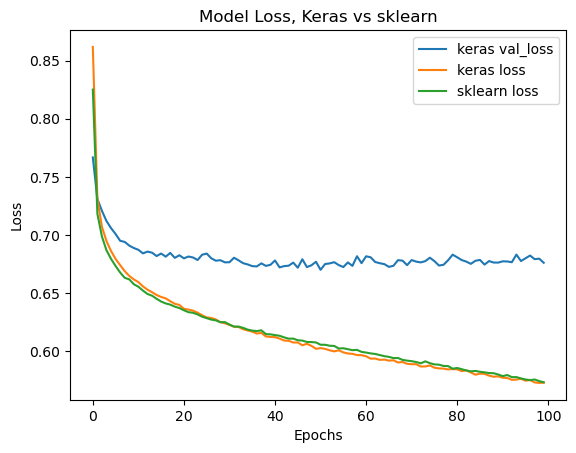

In [59]:
plt.plot(history_mdl.history["val_loss"])
plt.plot(history_mdl.history["loss"])
plt.plot(mlp.loss_curve_)
plt.title("Model Loss, Keras vs sklearn")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["keras val_loss", "keras loss","sklearn loss"], loc="upper right")
plt.show()

The training loss for the keras and sklearn models is very similar, with the curves closely following each other with number of epochs.

Accuracy for sklearn model: <br>75.1 => training set<br>
                            70.4 => testing set
                            
Accuracy for keras model: <br>74.5 => training set<br>
                          69.6 => testing set
                          
Therefore the accuracy between the keras and sklearn models is very similar, with the sklearn model showing slightly higher accuracy on both the training and testing sets.

## 5. Regularisation (1.5 marks)
---
This section covers **2** exercises on the impact of weight regularisaton. Note that $L_{1}$- and $L_{2}$-regularisation may also be applied to the activation of intermediate layers. Also, a similar regularising effect could be achieved using **dropout** regularisation, which you are encouraged to try out, but which we won't study in this CP exercise.

In [60]:
# Relevant import(s) for this section
from tensorflow.python.keras.regularizers import l1_l2

#### 5.1. Define `Keras` model factory method (0.5 mark)

- Define a python function called `big_model_fn` which takes the followng three arguments:
    - `l1`: A float specifying the $L_{1}$ regularisation factor (default value: 0)
    - `l2`: A float specifying the $L_{2}$ regularisation factor (default value: 0)
    - `name`: A string, specifying the name of the model (default value: None)
- Indside the function, you should:
    - Construct a `Keras` model using the functional API, which has:
        - An input layer with the same number of nodes as the number of features in `X`.
        - **Two** densely connected hidden layer with **100 nodes** each, both equipped with **ReLU activation**.
        - Both hidden layers should be subject to kernel regularisation (_i.e._ weight regularisation) with the regularisation factors specified as an input.
        - A densely connected output layer with **3 nodes** (the number of types of weather we're classifying) equipped with **softmax activation**.
        - A name given by the corresponding argument.
    - Compile the model in the same way as in **Exercise 14.**
- The function should return the compiled `Keras` model. 

The method will provide a convenient way of constructing and compiling a number of "big"/deep `Keras` models which differ only by their regularisation and name.

In [61]:
def big_model_fn(l1,l2,name):
    inputs = Input(shape=(23,))
    x1 = Dense(100, activation="relu",kernel_regularizer=l1_l2(l1=l1, l2=l2))(inputs)
    x2 = Dense(100, activation="relu",kernel_regularizer=l1_l2(l1=l1, l2=l2))(x1)
    outputs = Dense(3, activation="softmax")(x2)
    model = Model(inputs, outputs, name=name)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

#### 5.2. Train "big" models with and without regularisation (1 mark)

- Construct three "big" model using the factory method:
     - One with default parameters
     - One with `l1=0.003` and  `name='model_L1'`
     - One with `l2=0.03`  and `name='model_L2'`
- Train each one as in **Exercise 15.**
- Compare first the loss history of the un-regularised "big" model to that of the small model from **Exercise 15** using the `plot.loss()` method.
- Then, compare the loss histories of all three "big" models with that of the small model.
- Plot the loss and val loss of all 4 models. Target these points:
    - Compare the performance of deep vs shallow models on the testing sets
    - Compare the level of ovetraining (training vs testing loss)
    - Note: Don't be alarmed if the shallow network performs slightly better that the deeper ones, this is dataset dependant.
- Copy the same plotting code, but this time plot the training and validation accuracy
- Discuss the results.

In [62]:
model = big_model_fn(0,0,"model")
model_l1 = big_model_fn(0.003,0,"model_L1")
model_l2 = big_model_fn(0,0.03,"model_L2")

In [63]:
history_model = model.fit(x_train,y_train, epochs=100, batch_size=32, shuffle=True, validation_split=0.2)

C:\Users\Stefa\Anaconda3\envs\daml\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:1516: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/100
184/184 [==============================] - 1s 4ms/step - loss: 0.7704 - accuracy: 0.6366 - val_loss: 0.7086 - val_accuracy: 0.6646
Epoch 2/100
184/184 [==============================] - 1s 3ms/step - loss: 0.6884 - accuracy: 0.6813 - val_loss: 0.6877 - val_accuracy: 0.6871
Epoch 3/100
184/184 [==============================] - 1s 3ms/step - loss: 0.6707 - accuracy: 0.6900 - val_loss: 0.6835 - val_accuracy: 0.6912
Epoch 4/100
184/184 [==============================] - 1s 3ms/step - loss: 0.6582 - accuracy: 0.7003 - val_loss: 0.6763 - val_accuracy: 0.6918
Epoch 5/100
184/184 [==============================] - 1s 3ms/step - loss: 0.6457 - accuracy: 0.7041 - val_loss: 0.6678 - val_accuracy: 0.7014
Epoch 6/100
184/184 [==============================] - 1s 3ms/step - loss: 0.6377 - accuracy: 0.7077 - val_loss: 0.6664 - val_accuracy: 0.7020
Epoch 7/100
184/184 [==============================] - 1s 3ms/step - loss: 0.6272 - accuracy: 0.7141 - val_loss: 0.6571 - val_accuracy: 0.6986

Epoch 58/100
184/184 [==============================] - 1s 3ms/step - loss: 0.3149 - accuracy: 0.8772 - val_loss: 0.8221 - val_accuracy: 0.6898
Epoch 59/100
184/184 [==============================] - 1s 3ms/step - loss: 0.3122 - accuracy: 0.8736 - val_loss: 0.8564 - val_accuracy: 0.6864
Epoch 60/100
184/184 [==============================] - 1s 3ms/step - loss: 0.3059 - accuracy: 0.8772 - val_loss: 0.8620 - val_accuracy: 0.6939
Epoch 61/100
184/184 [==============================] - 1s 3ms/step - loss: 0.3006 - accuracy: 0.8816 - val_loss: 0.8432 - val_accuracy: 0.6980
Epoch 62/100
184/184 [==============================] - 1s 3ms/step - loss: 0.2956 - accuracy: 0.8825 - val_loss: 0.8534 - val_accuracy: 0.6864
Epoch 63/100
184/184 [==============================] - 1s 3ms/step - loss: 0.2914 - accuracy: 0.8854 - val_loss: 0.8583 - val_accuracy: 0.6864
Epoch 64/100
184/184 [==============================] - 1s 3ms/step - loss: 0.2843 - accuracy: 0.8951 - val_loss: 0.8702 - val_accuracy:

In [64]:
history_model_l1 = model_l1.fit(x_train,y_train, epochs=100, batch_size=32, shuffle=True, validation_split=0.2)

Epoch 1/100


C:\Users\Stefa\Anaconda3\envs\daml\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:1516: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


184/184 [==============================] - 1s 4ms/step - loss: 2.4103 - accuracy: 0.6398 - val_loss: 1.2676 - val_accuracy: 0.6531
Epoch 2/100
184/184 [==============================] - 1s 3ms/step - loss: 1.0260 - accuracy: 0.6656 - val_loss: 0.9208 - val_accuracy: 0.6463
Epoch 3/100
184/184 [==============================] - 1s 3ms/step - loss: 0.8766 - accuracy: 0.6626 - val_loss: 0.8605 - val_accuracy: 0.6565
Epoch 4/100
184/184 [==============================] - 1s 3ms/step - loss: 0.8340 - accuracy: 0.6650 - val_loss: 0.8304 - val_accuracy: 0.6238
Epoch 5/100
184/184 [==============================] - 1s 3ms/step - loss: 0.8112 - accuracy: 0.6648 - val_loss: 0.8166 - val_accuracy: 0.6612
Epoch 6/100
184/184 [==============================] - 1s 3ms/step - loss: 0.8029 - accuracy: 0.6645 - val_loss: 0.8074 - val_accuracy: 0.6476
Epoch 7/100
184/184 [==============================] - 1s 3ms/step - loss: 0.7945 - accuracy: 0.6677 - val_loss: 0.7980 - val_accuracy: 0.6510
Epoch 8/100

184/184 [==============================] - 1s 3ms/step - loss: 0.7395 - accuracy: 0.6791 - val_loss: 0.7423 - val_accuracy: 0.6653
Epoch 59/100
184/184 [==============================] - 1s 3ms/step - loss: 0.7384 - accuracy: 0.6798 - val_loss: 0.7448 - val_accuracy: 0.6612
Epoch 60/100
184/184 [==============================] - 1s 3ms/step - loss: 0.7393 - accuracy: 0.6762 - val_loss: 0.7456 - val_accuracy: 0.6776
Epoch 61/100
184/184 [==============================] - 1s 3ms/step - loss: 0.7401 - accuracy: 0.6789 - val_loss: 0.7432 - val_accuracy: 0.6646
Epoch 62/100
184/184 [==============================] - 0s 3ms/step - loss: 0.7367 - accuracy: 0.6769 - val_loss: 0.7422 - val_accuracy: 0.6721
Epoch 63/100
184/184 [==============================] - 1s 3ms/step - loss: 0.7375 - accuracy: 0.6787 - val_loss: 0.7447 - val_accuracy: 0.6755
Epoch 64/100
184/184 [==============================] - 1s 3ms/step - loss: 0.7362 - accuracy: 0.6813 - val_loss: 0.7426 - val_accuracy: 0.6735
Epoch

In [65]:
history_model_l2 = model_l2.fit(x_train,y_train, epochs=100, batch_size=32, shuffle=True, validation_split=0.2)

Epoch 1/100


C:\Users\Stefa\Anaconda3\envs\daml\lib\site-packages\tensorflow\python\keras\engine\data_adapter.py:1516: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


184/184 [==============================] - 2s 5ms/step - loss: 2.2201 - accuracy: 0.6245 - val_loss: 1.0126 - val_accuracy: 0.6469
Epoch 2/100
184/184 [==============================] - 1s 3ms/step - loss: 0.8700 - accuracy: 0.6602 - val_loss: 0.8195 - val_accuracy: 0.6565
Epoch 3/100
184/184 [==============================] - 1s 3ms/step - loss: 0.8038 - accuracy: 0.6587 - val_loss: 0.8068 - val_accuracy: 0.6537
Epoch 4/100
184/184 [==============================] - 1s 3ms/step - loss: 0.7941 - accuracy: 0.6561 - val_loss: 0.7989 - val_accuracy: 0.6381
Epoch 5/100
184/184 [==============================] - 1s 3ms/step - loss: 0.7827 - accuracy: 0.6571 - val_loss: 0.7862 - val_accuracy: 0.6660
Epoch 6/100
184/184 [==============================] - 1s 3ms/step - loss: 0.7814 - accuracy: 0.6645 - val_loss: 0.7788 - val_accuracy: 0.6388
Epoch 7/100
184/184 [==============================] - 1s 3ms/step - loss: 0.7771 - accuracy: 0.6597 - val_loss: 0.7727 - val_accuracy: 0.6497
Epoch 8/100

184/184 [==============================] - 1s 3ms/step - loss: 0.7316 - accuracy: 0.6791 - val_loss: 0.7367 - val_accuracy: 0.6633
Epoch 59/100
184/184 [==============================] - 1s 3ms/step - loss: 0.7285 - accuracy: 0.6784 - val_loss: 0.7367 - val_accuracy: 0.6633
Epoch 60/100
184/184 [==============================] - 1s 3ms/step - loss: 0.7306 - accuracy: 0.6748 - val_loss: 0.7416 - val_accuracy: 0.6816
Epoch 61/100
184/184 [==============================] - 1s 3ms/step - loss: 0.7309 - accuracy: 0.6789 - val_loss: 0.7385 - val_accuracy: 0.6619
Epoch 62/100
184/184 [==============================] - 1s 3ms/step - loss: 0.7281 - accuracy: 0.6782 - val_loss: 0.7405 - val_accuracy: 0.6714
Epoch 63/100
184/184 [==============================] - 1s 3ms/step - loss: 0.7290 - accuracy: 0.6784 - val_loss: 0.7349 - val_accuracy: 0.6605
Epoch 64/100
184/184 [==============================] - 1s 3ms/step - loss: 0.7282 - accuracy: 0.6796 - val_loss: 0.7360 - val_accuracy: 0.6667
Epoch

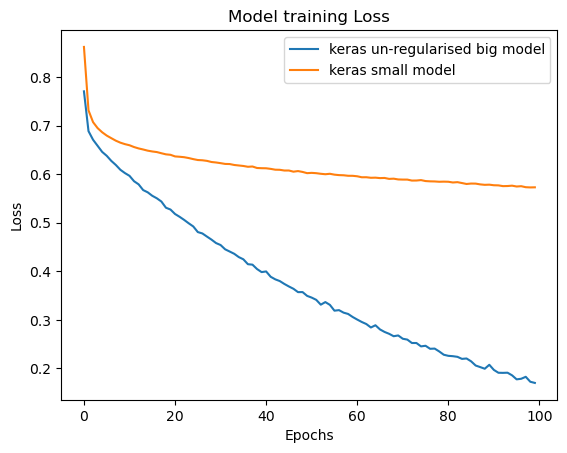

In [66]:
#plt.plot(history_mdl.history["val_loss"])
plt.plot(history_model.history["loss"])
plt.plot(history_mdl.history["loss"])
plt.title("Model training Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["keras un-regularised big model","keras small model"], loc="upper right")
plt.show()

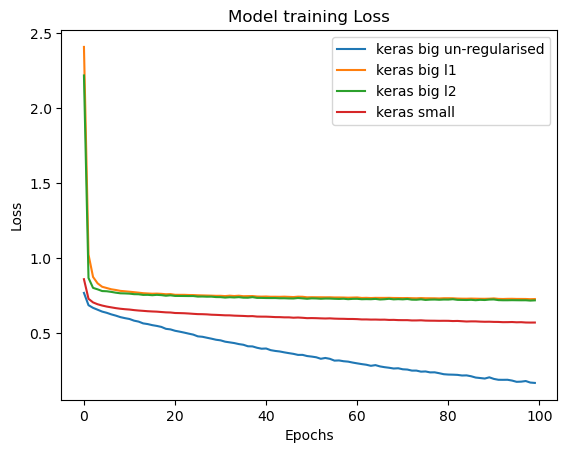

In [67]:
plt.plot(history_model.history["loss"])
plt.plot(history_model_l1.history["loss"])
plt.plot(history_model_l2.history["loss"])
plt.plot(history_mdl.history["loss"])
plt.title("Model training Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["keras big un-regularised","keras big l1","keras big l2","keras small"], loc="upper right")
plt.show()

The loss of the regularised models reaches a pleateau at the highest loss value, followed by the small model, with the un-regularised model having the lowest loss and no clear plateau.

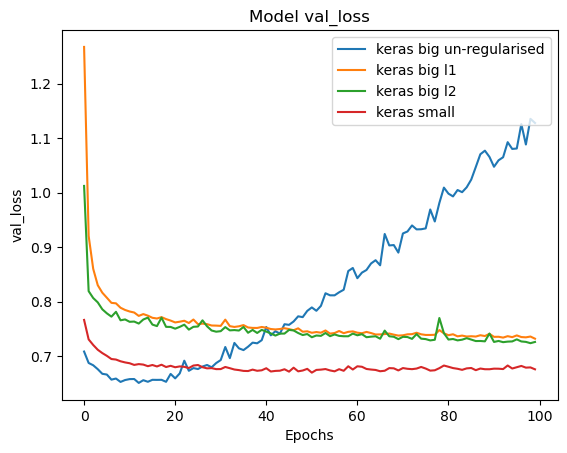

In [68]:
plt.plot(history_model.history["val_loss"])
plt.plot(history_model_l1.history["val_loss"])
plt.plot(history_model_l2.history["val_loss"])
plt.plot(history_mdl.history["val_loss"])
plt.title("Model val_loss")
plt.ylabel("val_loss")
plt.xlabel("Epochs")
plt.legend(["keras big un-regularised","keras big l1","keras big l2","keras small"], loc="upper right")
plt.show()

In terms of val_loss, the regularised models seem to be continuously improving, while the small model plateaus and seems to begin overfitting, with the val_loss eventually slowly rising. In contrast to the falling training loss for the un-regularised model, the un-regularised validation loss reaches a minimum very early and begins to overfit and dramatically rise in value. 

In [69]:
mdl.evaluate(x_test,y_test)#evaluating small keras model

99/99 [==============================] - 0s 2ms/step - loss: 0.6874 - accuracy: 0.6946


[0.687400221824646, 0.6946031451225281]

In [70]:
model.evaluate(x_test,y_test)#evaluating un-regularised keras model

99/99 [==============================] - 0s 2ms/step - loss: 1.2087 - accuracy: 0.6740


[1.2086703777313232, 0.6739682555198669]

In [71]:
model_l1.evaluate(x_test,y_test)#evaluating l1 keras

99/99 [==============================] - 0s 2ms/step - loss: 0.7291 - accuracy: 0.6889


[0.7291197180747986, 0.6888889074325562]

In [72]:
model_l2.evaluate(x_test,y_test)#evaluating l2 keras

99/99 [==============================] - 0s 2ms/step - loss: 0.7232 - accuracy: 0.6727


[0.7231905460357666, 0.672698438167572]

When evalauted on the testing set the small keras model has the lowest loss and the highest accuracy. The small keras model has the lowest loss as it does not have the addiditonal regularisation term included in the loss function. Therefore, it does not make much sense to compare the regularised and non-regularised loss values and the accuracy becomes the key performance comparison metric. With this in mind then in this case the small keras model performs the best out of the 4 models by having the highest accuracy. 

Out of the 4 models, the big un-regularised model suffers the most from overtraining and it has the lowest training loss and the highest testing loss. The small keras model also slightly suffers from overtraining as the training loss always goes down but the validation loss eventually begins to go up again. The two regularised models do not suffer from overtraining as their training and validation curves always decrease, with the testing set loss being similar to the the val_loss.

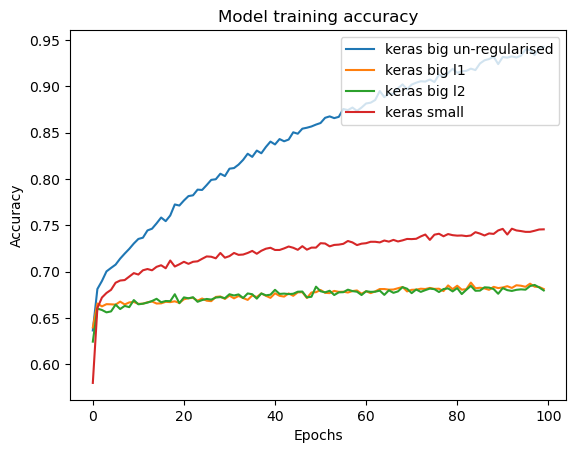

In [73]:
plt.plot(history_model.history["accuracy"])
plt.plot(history_model_l1.history["accuracy"])
plt.plot(history_model_l2.history["accuracy"])
plt.plot(history_mdl.history["accuracy"])
plt.title("Model training accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["keras big un-regularised","keras big l1","keras big l2","keras small"], loc="upper right")
plt.show()

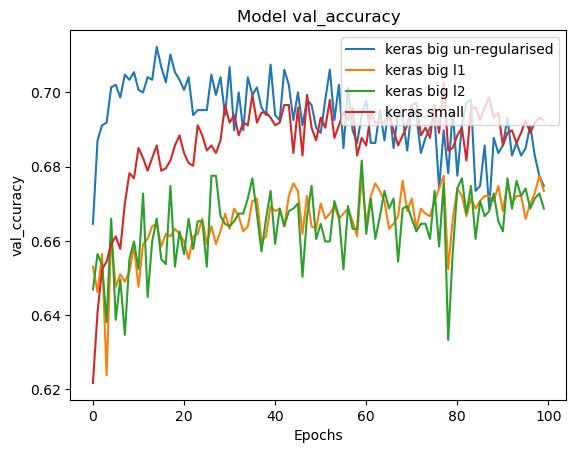

In [74]:
plt.plot(history_model.history["val_accuracy"])
plt.plot(history_model_l1.history["val_accuracy"])
plt.plot(history_model_l2.history["val_accuracy"])
plt.plot(history_mdl.history["val_accuracy"])
plt.title("Model val_accuracy")
plt.ylabel("val_ccuracy")
plt.xlabel("Epochs")
plt.legend(["keras big un-regularised","keras big l1","keras big l2","keras small"], loc="upper right")
plt.show()

The model training accuracy grows the fastest for the un-regularised keras model, followed by the small keras model, with the two regularised models plateauing the earliest.

In terms of the validation accuracy: The highest val-accuracy reached at any point is by the un-regularised big keras model, which would have had the best accuracy if the model weights were saved at that point. However, with further training the val_accuracy of the un-regularised model followed a downward trend. At the end of 100 epochs the small keras model had the highest val_accuracy which only increased with number of epochs. Both of the regularised models showed a slow but continously increasing val_accuracy with further training.